<a href="https://colab.research.google.com/github/ilyandho/FPL-Optimal-Transfer/blob/main/FPL_points_predictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [38]:
plt.rcParams["figure.figsize"] = (12,9)

# Read the data

In [39]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/fpl_player_data.csv').drop(columns=['Unnamed: 0'])


In [40]:
# Separate the week to be predicted
##
def get_details(gw):
    # player_data = pd.DataFrame(get_player_data(gw))

    # Separate next gw's data
    next_gw_data = df[df['gw'] == gw]

    # Drop this data from the rest of data
    player_data = df.drop(df[df['gw'] >= gw].index)

    return player_data #, next_gw_data


details = get_details(20)
details

,id,gw,team_h_difficulty,team_a_difficulty,position,minutes,goals_scored,assists,clean_sheets,goals_conceded,...,creativity,threat,ict_index,starts,expected_goals,expected_assists,expected_goal_involvements,expected_goals_conceded,total_points,in_dreamteam
0,1,1,2,5,4,0,0,0,0,0,...,0.0,0.0,0.0,0,0.0,0.0,0.0,0.00,0,False
1,2,1,2,5,2,0,0,0,0,0,...,0.0,0.0,0.0,0,0.0,0.0,0.0,0.00,0,False
2,3,1,2,5,3,0,0,0,0,0,...,0.0,0.0,0.0,0,0.0,0.0,0.0,0.00,0,False
3,4,1,2,5,3,0,0,0,0,0,...,0.0,0.0,0.0,0,0.0,0.0,0.0,0.00,0,False
4,5,1,2,5,2,4,0,0,0,0,...,0.0,0.0,0.0,0,0.0,0.0,0.0,0.02,1,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13850,768,19,3,3,2,0,0,0,0,0,...,0.0,0.0,0.0,0,0.0,0.0,0.0,0.00,0,False
13851,769,19,2,2,3,0,0,0,0,0,...,0.0,0.0,0.0,0,0.0,0.0,0.0,0.00,0,False
13852,770,19,2,2,3,0,0,0,0,0,...,0.0,0.0,0.0,0,0.0,0.0,0.0,0.00,0,False
13853,771,19,5,3,3,0,0,0,0,0,...,0.0,0.0,0.0,0,0.0,0.0,0.0,0.00,0,False


In [41]:
details.columns

Index(['id', 'gw', 'team_h_difficulty', 'team_a_difficulty', 'position',
       'minutes', 'goals_scored', 'assists', 'clean_sheets', 'goals_conceded',
       'own_goals', 'penalties_saved', 'penalties_missed', 'yellow_cards',
       'red_cards', 'saves', 'bonus', 'bps', 'influence', 'creativity',
       'threat', 'ict_index', 'starts', 'expected_goals', 'expected_assists',
       'expected_goal_involvements', 'expected_goals_conceded', 'total_points',
       'in_dreamteam'],
      dtype='object')

In [42]:
player_data = details
# next_gw_data = details[1]
# Of the features, we want to use features that are available at the time the model is running.
# This makes sure that the model only depends on games stats that are available before the match starts.
# These will store in the 'attributes' variable and we will subsquently be using these for the rest of the work.
attributes = ['id', 'team_h_difficulty', 'team_a_difficulty', 'position',
              'threat', 'ict_index', 'expected_goals', 'expected_assists',
              'expected_goal_involvements', 'expected_goals_conceded', 'total_points']
players_data = player_data[attributes]
players_data


,id,team_h_difficulty,team_a_difficulty,position,threat,ict_index,expected_goals,expected_assists,expected_goal_involvements,expected_goals_conceded,total_points
0,1,2,5,4,0.0,0.0,0.0,0.0,0.0,0.00,0
1,2,2,5,2,0.0,0.0,0.0,0.0,0.0,0.00,0
2,3,2,5,3,0.0,0.0,0.0,0.0,0.0,0.00,0
3,4,2,5,3,0.0,0.0,0.0,0.0,0.0,0.00,0
4,5,2,5,2,0.0,0.0,0.0,0.0,0.0,0.02,1
...,...,...,...,...,...,...,...,...,...,...,...
13850,768,3,3,2,0.0,0.0,0.0,0.0,0.0,0.00,0
13851,769,2,2,3,0.0,0.0,0.0,0.0,0.0,0.00,0
13852,770,2,2,3,0.0,0.0,0.0,0.0,0.0,0.00,0
13853,771,5,3,3,0.0,0.0,0.0,0.0,0.0,0.00,0


In [44]:
# Group the players by position
# Here we will train models for each position i.e each position will have its own model for predicting the data
goalkeepers = players_data.loc[players_data['position'] == 1].drop('position', axis='columns')
gk_feature = goalkeepers.drop('total_points', axis='columns')
gk_target = goalkeepers['total_points']


defenders = players_data.loc[players_data['position'] == 2].drop('position', axis='columns')
def_feature = defenders.drop('total_points', axis='columns')
def_target = defenders['total_points']


midfielders = players_data.loc[players_data['position'] == 3].drop('position', axis='columns')
mid_feature = midfielders.drop('total_points', axis='columns')
mid_target = midfielders['total_points']


forwards = players_data.loc[players_data['position'] == 4].drop('position', axis='columns')
for_feature = forwards.drop('total_points', axis='columns')
for_target = forwards['total_points']

### Train/Test split

In [47]:
from sklearn.model_selection import train_test_split

# goalkeepers
gk_ft_train, gk_ft_test, gk_tar_train, gk_tar_test = train_test_split(gk_feature, gk_target,
                                                   test_size=0.3, shuffle=True,
                                                   random_state=42)

# defenders
def_ft_train, def_ft_test, def_tar_train, def_tar_test = train_test_split(def_feature, def_target,
                                                   test_size=0.3, shuffle=True,
                                                  random_state=42)

# midfielders
mid_ft_train, mid_ft_test, mid_tar_train, mid_tar_test = train_test_split(mid_feature, mid_target,
                                                   test_size=0.3, shuffle=True,
                                                   random_state=42)

# midfielders
for_ft_train, for_ft_test, for_tar_train, for_tar_test = train_test_split(for_feature, for_target,
                                                   test_size=0.3, shuffle=True,
                                                   random_state=42)

# Baseline model: Gradient Boosting Classifier with all features

## Goalkeepers

In [54]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import accuracy_score

# Initialize classifier
gbr = GradientBoostingRegressor(max_depth=5, random_state=42)

# Train classifier using all features
gbr.fit(gk_ft_train, gk_tar_train)

# Make predictions
preds = gbr.predict(gk_ft_test)

# Evaluate the model using the F1-score
# f1_score_all = round(f1_score(gk_tar_test, preds, average='weighted'), 3)

gbr.score(gk_ft_test, gk_tar_test)

0.5433640636801018

### Feature selection techniques

#### Variance threshold

In [56]:
X_train_v1, X_test_v1, y_tain_v1, y_test_v1 = gk_ft_train.copy(), gk_ft_test.copy(), gk_tar_train.copy(), gk_tar_test.copy()

In [57]:
# Calculate the variance of each feature
X_train_v1.var(axis=0)

id                            4.483330e+04
team_h_difficulty             1.029636e+00
team_a_difficulty             1.331505e+00
threat                        1.420959e-02
ict_index                     1.572077e+00
expected_goals                3.552398e-07
expected_assists              2.806236e-06
expected_goal_involvements    3.154529e-06
expected_goals_conceded       6.104354e-01
dtype: float64

In [58]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

scaled_X_train_v1 = scaler.fit_transform(X_train_v1)

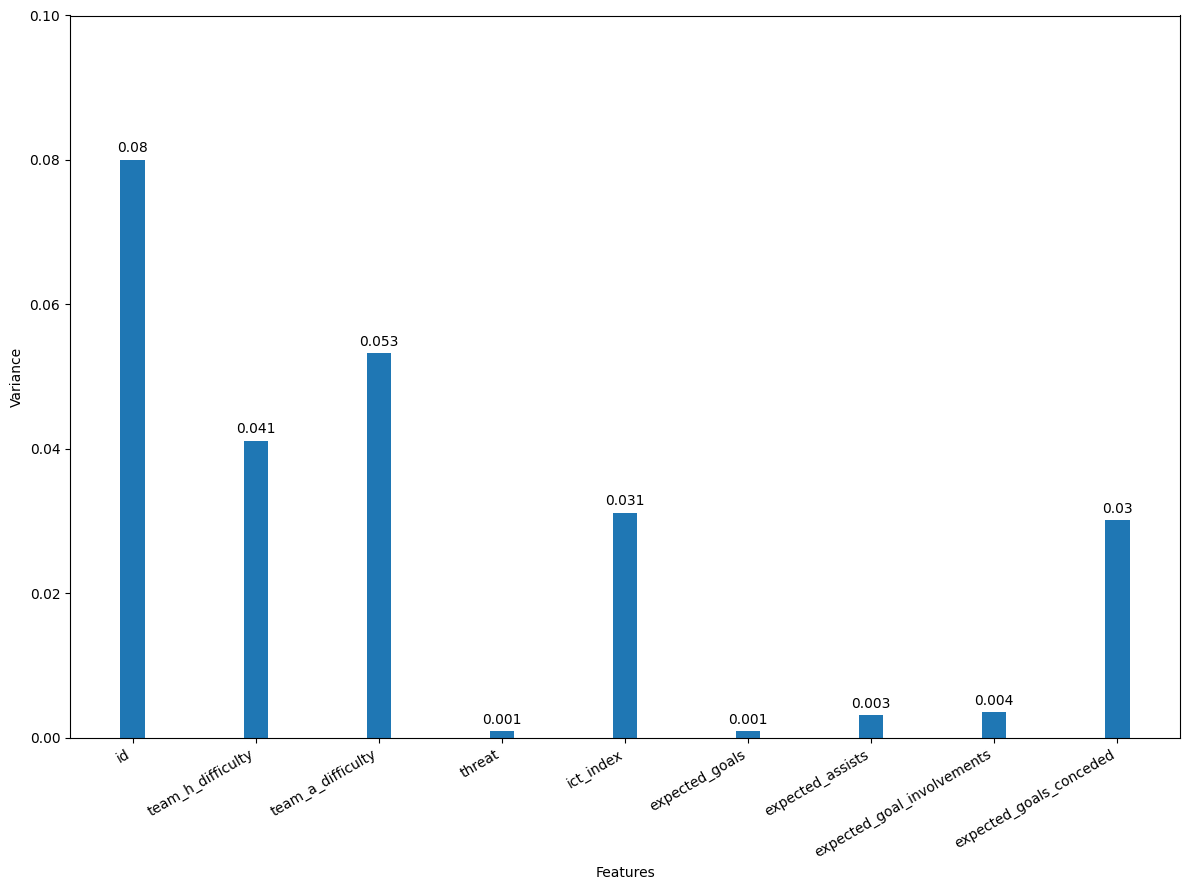

In [60]:
fig, ax = plt.subplots()

x = gk_feature.columns
y = scaled_X_train_v1.var(axis=0)

ax.bar(x, y, width=0.2)
ax.set_xlabel('Features')
ax.set_ylabel('Variance')
ax.set_ylim(0, 0.1)

for index, value in enumerate(y):
    plt.text(x=index, y=value+0.001, s=str(round(value, 3)), ha='center')

fig.autofmt_xdate()
plt.tight_layout()